<a href="https://colab.research.google.com/github/PrajjwalNakarmi/Applied-Machine-Learning/blob/main/Hate_Speech_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re #used for text cleaning (URLs, punctuation, numbers, etc.)
import nltk #Natural Language Toolkit for stop words and lemmatization
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('stopwords') #list of common English words like is, the, and
nltk.download('wordnet') #required for lemmatization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
url = "https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv"
df = pd.read_csv(url)

# Keeping only required columns
df = df[['tweet', 'class']]
df.columns = ['text', 'label']

df.head()

,text,label
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1


In [3]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [4]:
def preprocess_text(text):
    # Converting text to lowercase
    text = text.lower()

    # Removing URLs from the dataseing
    text = re.sub(r'http\S+|www\S+', '', text)

    # Removing mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Removing numbers and punctuation
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenization
    tokens = text.split()

    # Removing stop words and apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)


In [5]:
df['clean_text'] = df['text'].apply(preprocess_text)

df[['text', 'clean_text']].head()


,text,clean_text
0,!!! RT @mayasolovely: As a woman you shouldn't...,rt woman shouldnt complain cleaning house amp ...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,rt boy dat coldtyga dwn bad cuffin dat hoe st ...
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,rt dawg rt ever fuck bitch start cry confused ...
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,rt look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,rt shit hear might true might faker bitch told ya


In [6]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [7]:
tfidf = TfidfVectorizer(
    #max_features=1000,
    #max_features=200,
    #max_features=100,
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


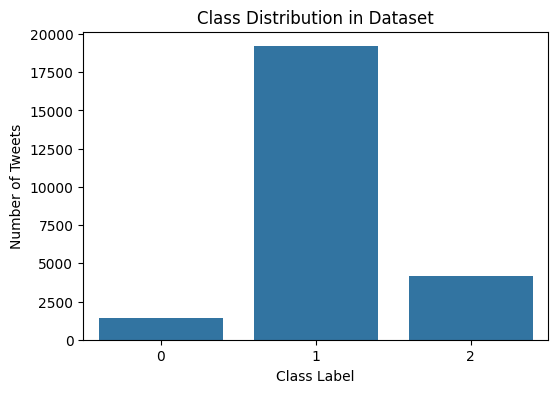

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Class Distribution in Dataset")
plt.xlabel("Class Label")
plt.ylabel("Number of Tweets")
plt.show()

In [9]:
#lr = LogisticRegression(max_iter=1000)
#lr = LogisticRegression(max_iter=200)
#lr = LogisticRegression(max_iter=100)
lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_tfidf, y_train)



LogisticRegression(max_iter=5000)

In [10]:
y_pred_lr = lr.predict(X_test_tfidf)
print("Logistic Regession Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_lr, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_lr, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr))
#Accuracy: 0.8886423239862821
#Accuracy: 0.8743191446439379
#Accuracy: 0.8704861811579584
#Accuracy: 0.8904579382691143
#Accuracy: 0.8926770223925762 when ngram not specified

Logistic Regession Accuracy: 0.8904579382691143
Precision: 0.8785004301191701
Recall: 0.8904579382691143
F1-score: 0.8764690773109608

Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.18      0.28       286
           1       0.91      0.96      0.93      3838
           2       0.84      0.80      0.82       833

    accuracy                           0.89      4957
   macro avg       0.79      0.65      0.68      4957
weighted avg       0.88      0.89      0.88      4957



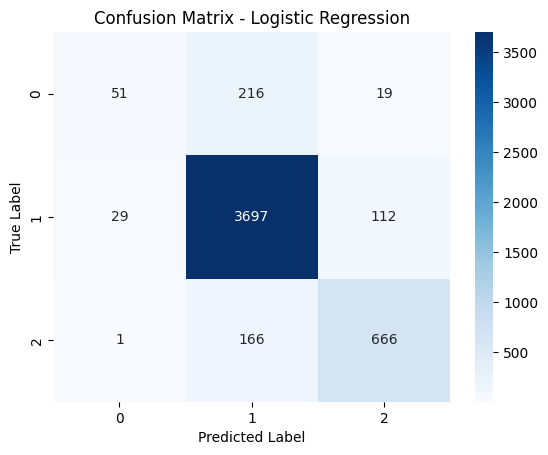

In [11]:
lr_cm = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

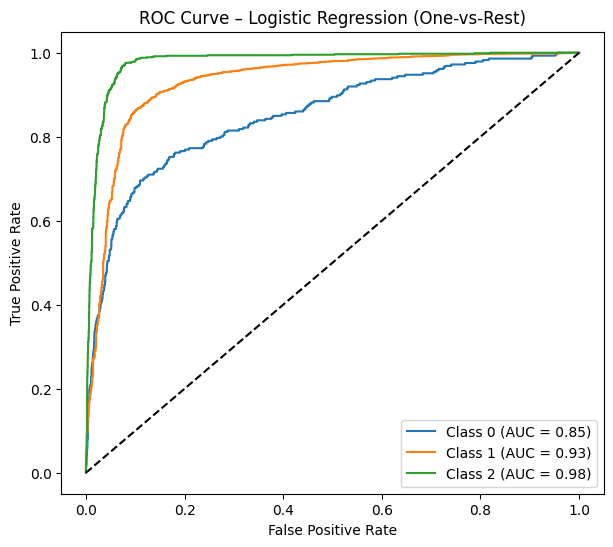

In [12]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = lr.predict_proba(X_test_tfidf)

n_classes = y_test_bin.shape[1]

plt.figure(figsize=(7,6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Logistic Regression (One-vs-Rest)')
plt.legend(loc='lower right')
plt.show()



In [13]:
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)


LinearSVC()

In [28]:
y_pred_svm = svm.predict(X_test_tfidf)

print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred_svm, average='weighted'))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr))

#SVM Accuracy: 0.8896509985878556
#SVM Accuracy: 0.8741174097236232
#SVM Accuracy: 0.8690740367157554
#SVM Accuracy: 0.886624974783135
#SVM Accuracy: 0.8831954811377849 when ngram not specified

SVM Accuracy: 0.886624974783135
Precision: 0.8749732444906545
Recall: 0.886624974783135
F1-score: 0.8777530474895765

Classification Report:

              precision    recall  f1-score   support

           0       0.63      0.18      0.28       286
           1       0.91      0.96      0.93      3838
           2       0.84      0.80      0.82       833

    accuracy                           0.89      4957
   macro avg       0.79      0.65      0.68      4957
weighted avg       0.88      0.89      0.88      4957



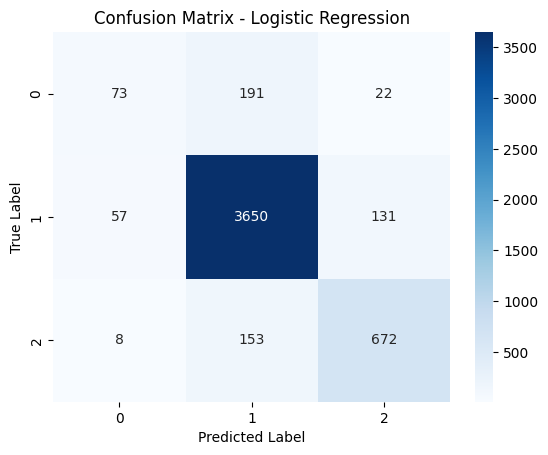

In [15]:
svm_cm = confusion_matrix(y_test, y_pred_svm)

sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

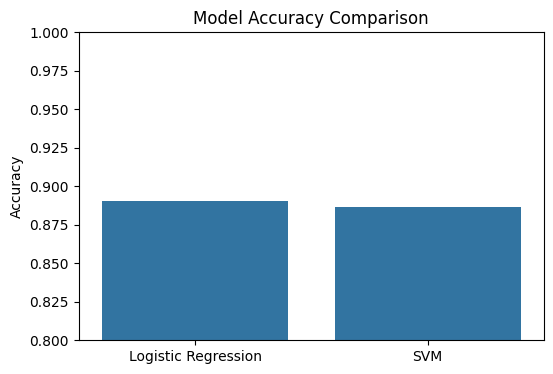

In [16]:
lr_accuracy = accuracy_score(y_test, y_pred_lr)
svm_accuracy = accuracy_score(y_test, y_pred_svm)

models = ['Logistic Regression', 'SVM']
accuracies = [lr_accuracy, svm_accuracy]

plt.figure(figsize=(6,4))
sns.barplot(x=models, y=accuracies)
plt.ylim(0.8, 1.0)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

In [18]:
def predict_tweet(text, model, vectorizer):
    cleaned = preprocess_text(text)
    vectorized = vectorizer.transform([cleaned])
    prediction = model.predict(vectorized)[0]
    return prediction


In [19]:
sample_tweet = "I like this tree"

pred = predict_tweet(sample_tweet, svm, tfidf)
print("Tweet:", sample_tweet)
print("Predicted Class:", pred)
#contxt dont understand and sarcasm also

Tweet: I like this tree
Predicted Class: 1


In [20]:
feature_names = tfidf.get_feature_names_out()


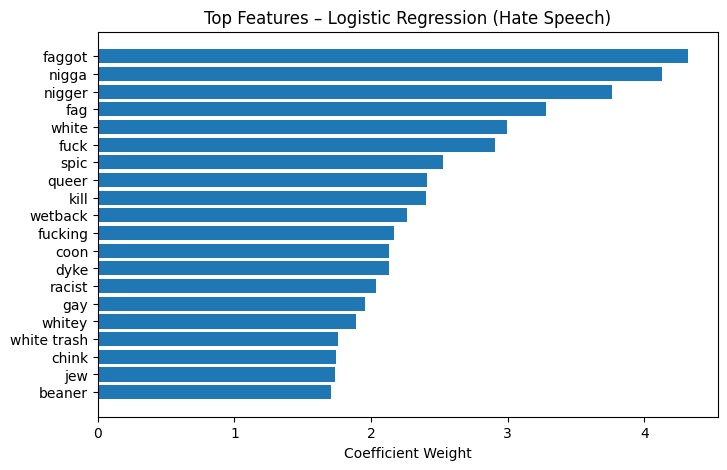

In [21]:
# Coefficients for class 0 (Hate Speech)
lr_coefs = lr.coef_[0]

# Get top 20 features
top_lr_idx = np.argsort(lr_coefs)[-20:]
top_lr_features = feature_names[top_lr_idx]
top_lr_values = lr_coefs[top_lr_idx]

# Plot
plt.figure(figsize=(8,5))
plt.barh(top_lr_features, top_lr_values)
plt.xlabel("Coefficient Weight")
plt.title("Top Features – Logistic Regression (Hate Speech)")
plt.show()


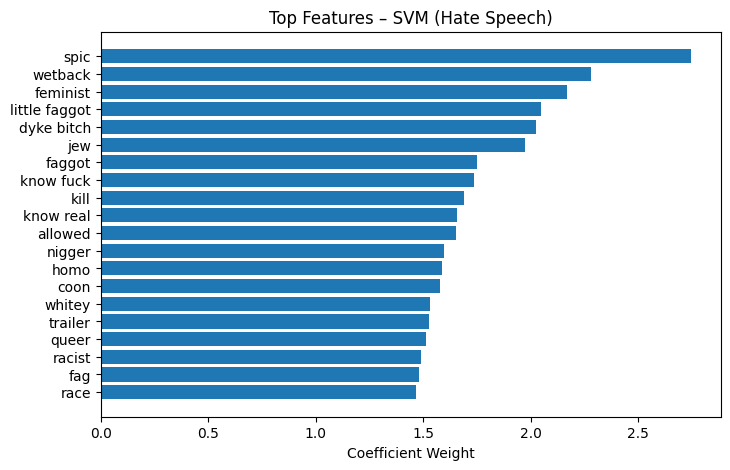

In [22]:
svm_coefs = svm.coef_[0]

top_svm_idx = np.argsort(svm_coefs)[-20:]
top_svm_features = feature_names[top_svm_idx]
top_svm_values = svm_coefs[top_svm_idx]

plt.figure(figsize=(8,5))
plt.barh(top_svm_features, top_svm_values)
plt.xlabel("Coefficient Weight")
plt.title("Top Features – SVM (Hate Speech)")
plt.show()


In [23]:
# Training accuracy
y_train_pred_lr = lr.predict(X_train_tfidf)
train_acc_lr = accuracy_score(y_train, y_train_pred_lr)

# Testing accuracy
y_test_pred_lr = lr.predict(X_test_tfidf)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)

print("Logistic Regression Training Accuracy:", train_acc_lr)
print("Logistic Regression Testing Accuracy:", test_acc_lr)

Logistic Regression Training Accuracy: 0.9277211742156763
Logistic Regression Testing Accuracy: 0.8904579382691143


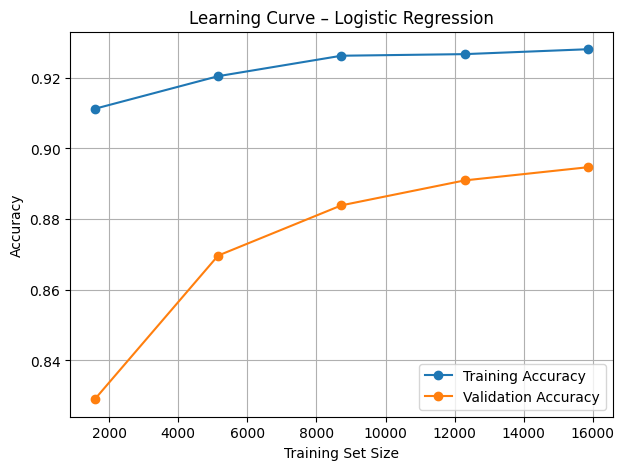

In [24]:
train_sizes, train_scores, test_scores = learning_curve(
    LogisticRegression(max_iter=100),
    X_train_tfidf,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve – Logistic Regression")
plt.legend()
plt.grid()
plt.show()

In [25]:
# Training accuracy
y_train_pred_svm = svm.predict(X_train_tfidf)
train_acc_svm = accuracy_score(y_train, y_train_pred_svm)

# Testing accuracy
y_test_pred_svm = svm.predict(X_test_tfidf)
test_acc_svm = accuracy_score(y_test, y_test_pred_svm)

print("SVM Training Accuracy:", train_acc_svm)
print("SVM Testing Accuracy:", test_acc_svm)


SVM Training Accuracy: 0.9491576717441743
SVM Testing Accuracy: 0.886624974783135


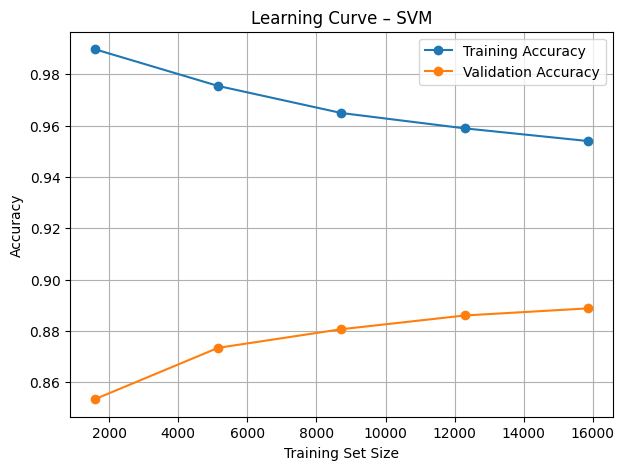

In [26]:
train_sizes, train_scores, test_scores = learning_curve(
    svm,
    X_train_tfidf,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve – SVM")
plt.legend()
plt.grid()
plt.show()
